<a href="https://colab.research.google.com/github/parment1/CAS-Advanced-Data-Science-/blob/main/RNN_Nasdaq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque


In [ ]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [ ]:
SCALE = True
scale_str = f"sc-{int(SCALE)}"
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
TEST_SIZE = 0.2
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
date_now = time.strftime("%Y-%m-%d")

### model parameters

layers = 2
cell = LSTM
units = 256
dropout = 0.3
bidirectional = False
steps = 15
lookup_step = 3

### training parameters

loss = "mae"
optimizer = "adamax"
batc = 10
epochs = 30

ticker = "NDAQ"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{loss}-{optimizer}-{cell.__name__}-seq-{steps}-step-{lookup_step}-layers-{layers}-units-{units}"
if bidirectional:
    model_name += "-b"

In [ ]:
def shuffle_in_unison(a, b):
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    if isinstance(ticker, str):
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        df = ticker
    else:
        raise TypeError("ticker can be a str")

    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()

    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' not in DF."

    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index

    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler

        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler

    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)

    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    
    # drop NaNs
    df.dropna(inplace=True)

    sequence_data = []
    sequences = deque(maxlen=n_steps)

    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])

    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)

    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)

    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)

    return result

In [ ]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [ ]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")

if not os.path.isdir("logs"):
    os.mkdir("logs")

if not os.path.isdir("data"):
    os.mkdir("data")

# load the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)

# save the dataframe
data["df"].to_csv(ticker_data_filename)

# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

In [ ]:
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Epoch 1/30
401/402 [============================>.] - ETA: 0s - loss: 5.8588e-04 - mean_absolute_error: 0.0188
Epoch 1: val_loss improved from inf to 0.00010, saving model to results\2022-06-28_NDAQ-sh-1-sc-1-sbd-0-mae-adamax-LSTM-seq-15-step-3-layers-2-units-256.h5
402/402 [==============================] - 25s 46ms/step - loss: 5.8560e-04 - mean_absolute_error: 0.0187 - val_loss: 9.7637e-05 - val_mean_absolute_error: 0.0093
Epoch 2/30
402/402 [==============================] - ETA: 0s - loss: 3.2193e-04 - mean_absolute_error: 0.0158
Epoch 2: val_loss did not improve from 0.00010
402/402 [==============================] - 17s 42ms/step - loss: 3.2193e-04 - mean_absolute_error: 0.0158 - val_loss: 2.6044e-04 - val_mean_absolute_error: 0.0157
Epoch 3/30
401/402 [============================>.] - ETA: 0s - loss: 3.6629e-04 - mean_absolute_error: 0.0166
Epoch 3: val_loss did not improve from 0.00010
402/402 [==============================] - 15s 36ms/step - loss: 3.6740e-04 - mean_absolute

402/402 [==============================] - ETA: 0s - loss: 1.8110e-04 - mean_absolute_error: 0.0120
Epoch 25: val_loss did not improve from 0.00005
402/402 [==============================] - 16s 40ms/step - loss: 1.8110e-04 - mean_absolute_error: 0.0120 - val_loss: 6.0787e-05 - val_mean_absolute_error: 0.0082
Epoch 26/30
401/402 [============================>.] - ETA: 0s - loss: 1.8525e-04 - mean_absolute_error: 0.0120
Epoch 26: val_loss did not improve from 0.00005
402/402 [==============================] - 16s 40ms/step - loss: 1.8589e-04 - mean_absolute_error: 0.0120 - val_loss: 6.2829e-05 - val_mean_absolute_error: 0.0081
Epoch 27/30
402/402 [==============================] - ETA: 0s - loss: 1.7000e-04 - mean_absolute_error: 0.0119
Epoch 27: val_loss did not improve from 0.00005
402/402 [==============================] - 16s 41ms/step - loss: 1.7000e-04 - mean_absolute_error: 0.0119 - val_loss: 5.8160e-05 - val_mean_absolute_error: 0.0067
Epoch 28/30
402/402 [======================

In [ ]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    """
    This function plots true close price along with predicted close price
    with blue and red colors respectively
    """
    plt.plot(test_df[f'true_adjclose_{lookup_step}'], c='b')
    plt.plot(test_df[f'adjclose_{lookup_step}'], c='g')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["real Price", "Estimated Price"])
    plt.show()

In [ ]:
def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset
    """
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [ ]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [ ]:
# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [ ]:
# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [ ]:
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

In [ ]:
# predict the future price
future_price = predict(model, data)

In [ ]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

In [ ]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}USD")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total B profit:", total_buy_profit)
print("Total S profit:", total_sell_profit)
print("Total P&L:", total_profit)
print("Profit:", profit_per_trade)

Future price after 3 days is 157.60USD
huber_loss loss: 5.335121022653766e-05
Mean Absolute Error: 5.833778179176693
Accuracy score: 0.5268924302788844
Total B profit: 137.11113214492784
Total S profit: 32.72024059295659
Total P&L: 169.83137273788444
Profit: 0.16915475372299246


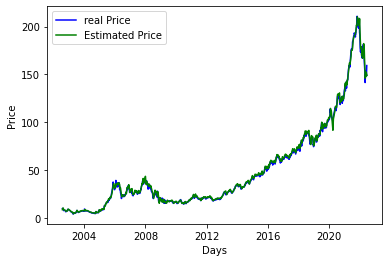

In [ ]:
# plot true/pred prices graph
plot_graph(final_df)

In [ ]:
final_df.head(20)

,open,high,low,close,adjclose,volume,ticker,adjclose_3,true_adjclose_3,buy_profit,sell_profit
2002-07-26,10.15,10.15,10.15,10.15,8.563499,0,NDAQ,8.670517,10.124336,1.560837,0.000000
2002-07-30,11.25,11.85,11.25,11.50,9.702489,8900,NDAQ,9.466700,9.955597,0.000000,-0.253108
2002-08-01,11.80,11.90,11.80,11.80,9.955597,4300,NDAQ,10.456723,10.124336,0.168739,0.000000
2002-08-02,11.80,11.80,11.80,11.80,9.955597,0,NDAQ,10.669705,10.166521,0.210924,0.000000
2002-08-13,12.20,12.20,12.10,12.20,10.293074,3900,NDAQ,10.778397,10.250890,-0.042184,0.000000
2002-08-14,12.15,12.20,12.15,12.20,10.293074,3700,NDAQ,10.779782,9.829041,-0.464032,0.000000
2002-08-30,10.30,10.30,10.00,10.00,8.436941,4200,NDAQ,8.905578,7.846358,-0.590583,0.000000
2002-09-09,9.75,9.90,9.70,9.80,8.268207,26000,NDAQ,8.406970,8.352575,0.084369,0.000000
2002-09-10,9.90,9.95,9.82,9.90,8.352575,36200,NDAQ,8.597321,8.386324,0.033749,0.000000
2002-09-12,10.10,10.10,9.90,9.90,8.352575,4000,NDAQ,8.937477,8.352575,0.000000,0.000000


In [ ]:
final_df.tail(20)

,open,high,low,close,adjclose,volume,ticker,adjclose_3,true_adjclose_3,buy_profit,sell_profit
2021-12-02,200.020004,203.080002,198.100006,201.229996,199.803787,940700,NDAQ,199.734787,204.093170,0.000000,-4.289383
2021-12-03,203.080002,203.910004,196.149994,200.119995,198.701645,882800,NDAQ,198.671997,205.920135,0.000000,-7.218491
2022-01-10,191.839996,192.949997,185.860001,189.119995,187.779617,1776800,NDAQ,191.508972,185.893082,-1.886536,0.000000
2022-02-08,177.770004,178.520004,174.679993,177.860001,176.599442,727300,NDAQ,176.419876,171.148331,0.000000,5.451111
2022-02-11,177.190002,177.589996,171.880005,172.369995,171.148331,1101600,NDAQ,175.145462,173.422104,2.273773,0.000000
2022-02-24,161.309998,170.960007,161.000000,170.190002,168.983795,1201800,NDAQ,167.412094,168.785202,0.000000,0.198593
2022-02-28,170.619995,172.759995,169.589996,171.149994,169.936981,1089000,NDAQ,168.015778,171.257553,0.000000,-1.320572
2022-03-03,173.289993,173.710007,171.089996,172.479996,171.257553,577600,NDAQ,169.329498,163.830566,0.000000,7.426987
2022-03-10,166.360001,167.300003,162.580002,166.479996,165.830994,879200,NDAQ,165.848831,168.918915,3.087921,0.000000
2022-03-16,170.779999,174.100006,169.419998,173.320007,172.644333,585800,NDAQ,166.715332,176.947495,0.000000,-4.303162


In [ ]:
tensorboard --logdir="logs"


SyntaxError: cannot assign to operator (<ipython-input-59-87357480c861>, line 1)